# Deep Q-learning (DQL) or Deep Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [3]:
import numpy as np

In [4]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [5]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [6]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [7]:
# batch[0], batch[0][1].shape

In [8]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [9]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [10]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, states, targetQs, is_training

In [11]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [12]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [13]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [14]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [15]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [16]:
def model_loss(actions, states, targetQs, action_size, hidden_size, is_training=False):
    
    actions_logits = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                       is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    
    loss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits, loss

In [17]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=d_vars)

    return opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.is_training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(action_size=action_size, hidden_size=hidden_size,
                                                    states=self.states, actions=self.actions, 
                                                    targetQs=self.targetQs, is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [19]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [20]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [21]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-04         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20             # experience mini-batch size
gamma = 0.99                 # future reward discount

In [22]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [23]:
# state = env.reset()

# for _ in range(memory_size):
    
#     action = env.action_space.sample()
    
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
def learn(sess, memory, batch_size):
    
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    
    next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states, 
                                                                      model.is_training: False})
    
    nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.is_training: False})
    return loss

In [25]:
def act(sess, state):
    
    action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                              model.is_training: False})
    
    action = np.argmax(action_logits, axis=1)[0]
    #print(action)
    
    return action

In [24]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step)
            
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done)])
            
            total_reward += reward
            state = next_state

            # Training
            if len(memory.buffer) >= batch_size:
                loss = learn(sess, memory, batch_size)
                loss_batch.append(loss)
            
            if done is True:
                break
                
        if len(memory.buffer) >= batch_size:
            episode_reward.append(total_reward)

            print('Episode:{}'.format(ep),
                  'meanR:{:.4f}'.format(np.mean(episode_reward)),
                  'R:{}'.format(total_reward),
                  'loss:{:.4f}'.format(np.mean(loss_batch)),
                  'exploreP:{:.4f}'.format(explore_p))

            # Ploting out
            episode_rewards_list.append([ep, np.mean(episode_reward)])
            rewards_list.append([ep, total_reward])
            loss_list.append([ep, np.mean(loss_batch)])

            # Break episode/epoch loop
            if np.mean(episode_reward) >= 500:
                break
                
        else: print('len(memory.buffer) < batch_size', len(memory.buffer), batch_size)
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

len(memory.buffer) < batch_size 14 20
Episode:1 meanR:13.0000 R:13.0 loss:1.1100 exploreP:0.9973
Episode:2 meanR:13.0000 R:13.0 loss:1.1357 exploreP:0.9960
Episode:3 meanR:14.0000 R:16.0 loss:1.1424 exploreP:0.9945
Episode:4 meanR:15.7500 R:21.0 loss:1.1484 exploreP:0.9924
Episode:5 meanR:17.4000 R:24.0 loss:1.1872 exploreP:0.9901
Episode:6 meanR:16.6667 R:13.0 loss:1.2499 exploreP:0.9888
Episode:7 meanR:17.2857 R:21.0 loss:1.2149 exploreP:0.9867
Episode:8 meanR:17.7500 R:21.0 loss:1.2078 exploreP:0.9847
Episode:9 meanR:17.7778 R:18.0 loss:1.2370 exploreP:0.9829
Episode:10 meanR:17.7000 R:17.0 loss:1.2289 exploreP:0.9813
Episode:11 meanR:17.3636 R:14.0 loss:1.2786 exploreP:0.9799
Episode:12 meanR:17.4167 R:18.0 loss:1.2696 exploreP:0.9782
Episode:13 meanR:18.3077 R:29.0 loss:1.3517 exploreP:0.9754
Episode:14 meanR:19.0000 R:28.0 loss:1.4419 exploreP:0.9727
Episode:15 meanR:19.7333 R:30.0 loss:1.5502 exploreP:0.9698
Episode:16 meanR:19.4375 R:15.0 loss:1.6027 exploreP:0.9683
Episode:17 

Episode:137 meanR:20.0000 R:35.0 loss:14.2627 exploreP:0.7616
Episode:138 meanR:19.8600 R:11.0 loss:14.9125 exploreP:0.7608
Episode:139 meanR:19.7300 R:17.0 loss:15.3143 exploreP:0.7595
Episode:140 meanR:19.3900 R:11.0 loss:21.2672 exploreP:0.7587
Episode:141 meanR:19.4200 R:14.0 loss:15.7751 exploreP:0.7576
Episode:142 meanR:19.7600 R:47.0 loss:23.0198 exploreP:0.7541
Episode:143 meanR:19.6400 R:20.0 loss:18.7061 exploreP:0.7526
Episode:144 meanR:19.6900 R:16.0 loss:24.4961 exploreP:0.7514
Episode:145 meanR:19.6300 R:11.0 loss:21.7325 exploreP:0.7506
Episode:146 meanR:19.4400 R:13.0 loss:13.8062 exploreP:0.7497
Episode:147 meanR:19.4700 R:16.0 loss:16.2119 exploreP:0.7485
Episode:148 meanR:19.6300 R:30.0 loss:17.0872 exploreP:0.7463
Episode:149 meanR:19.8600 R:40.0 loss:16.7711 exploreP:0.7433
Episode:150 meanR:19.8800 R:12.0 loss:8.7514 exploreP:0.7425
Episode:151 meanR:19.8500 R:25.0 loss:23.4892 exploreP:0.7406
Episode:152 meanR:19.7700 R:13.0 loss:21.0664 exploreP:0.7397
Episode:1

Episode:272 meanR:44.7100 R:62.0 loss:19.8460 exploreP:0.4596
Episode:273 meanR:44.1800 R:49.0 loss:22.0791 exploreP:0.4574
Episode:274 meanR:45.0400 R:101.0 loss:17.1537 exploreP:0.4529
Episode:275 meanR:45.3400 R:45.0 loss:14.1160 exploreP:0.4509
Episode:276 meanR:45.4300 R:27.0 loss:14.8158 exploreP:0.4497
Episode:277 meanR:45.5900 R:47.0 loss:18.6640 exploreP:0.4477
Episode:278 meanR:45.6900 R:27.0 loss:25.4032 exploreP:0.4465
Episode:279 meanR:45.6000 R:36.0 loss:17.2193 exploreP:0.4449
Episode:280 meanR:45.2200 R:12.0 loss:30.8385 exploreP:0.4444
Episode:281 meanR:45.3300 R:29.0 loss:25.7728 exploreP:0.4432
Episode:282 meanR:45.1900 R:31.0 loss:16.6690 exploreP:0.4418
Episode:283 meanR:45.4800 R:51.0 loss:15.4870 exploreP:0.4396
Episode:284 meanR:45.5500 R:79.0 loss:20.6357 exploreP:0.4362
Episode:285 meanR:45.8600 R:72.0 loss:24.6865 exploreP:0.4332
Episode:286 meanR:45.0500 R:25.0 loss:24.8840 exploreP:0.4321
Episode:287 meanR:45.1200 R:30.0 loss:23.0255 exploreP:0.4309
Episode

Episode:405 meanR:64.1000 R:73.0 loss:39.3953 exploreP:0.2130
Episode:406 meanR:65.0400 R:163.0 loss:29.7882 exploreP:0.2097
Episode:407 meanR:64.7300 R:56.0 loss:32.5194 exploreP:0.2086
Episode:408 meanR:65.6000 R:123.0 loss:38.9667 exploreP:0.2061
Episode:409 meanR:66.1600 R:114.0 loss:35.1959 exploreP:0.2039
Episode:410 meanR:66.8100 R:161.0 loss:34.9294 exploreP:0.2008
Episode:411 meanR:67.0900 R:67.0 loss:29.0104 exploreP:0.1995
Episode:412 meanR:67.0000 R:59.0 loss:48.1165 exploreP:0.1984
Episode:413 meanR:67.8800 R:128.0 loss:34.5001 exploreP:0.1960
Episode:414 meanR:67.6600 R:51.0 loss:36.5176 exploreP:0.1951
Episode:415 meanR:68.1600 R:81.0 loss:37.7596 exploreP:0.1936
Episode:416 meanR:68.3400 R:68.0 loss:30.6831 exploreP:0.1923
Episode:417 meanR:68.7100 R:73.0 loss:43.0645 exploreP:0.1910
Episode:418 meanR:69.4900 R:109.0 loss:32.4608 exploreP:0.1891
Episode:419 meanR:70.5700 R:163.0 loss:42.3695 exploreP:0.1862
Episode:420 meanR:71.1900 R:108.0 loss:34.6323 exploreP:0.1843


Episode:535 meanR:291.5300 R:500.0 loss:160.6230 exploreP:0.0177
Episode:536 meanR:295.4600 R:500.0 loss:165.9473 exploreP:0.0174
Episode:537 meanR:298.3900 R:422.0 loss:169.1685 exploreP:0.0171
Episode:538 meanR:300.7700 R:314.0 loss:211.7427 exploreP:0.0168
Episode:539 meanR:304.9600 R:497.0 loss:202.4441 exploreP:0.0165
Episode:540 meanR:308.5500 R:500.0 loss:234.8540 exploreP:0.0162
Episode:541 meanR:313.0500 R:500.0 loss:233.8524 exploreP:0.0159
Episode:542 meanR:316.7800 R:500.0 loss:205.8622 exploreP:0.0156
Episode:543 meanR:320.8900 R:500.0 loss:220.4528 exploreP:0.0153
Episode:544 meanR:325.0900 R:500.0 loss:235.2460 exploreP:0.0151
Episode:545 meanR:329.1300 R:500.0 loss:257.7004 exploreP:0.0148
Episode:546 meanR:332.0500 R:500.0 loss:267.9042 exploreP:0.0146
Episode:547 meanR:336.0100 R:500.0 loss:297.1401 exploreP:0.0144
Episode:548 meanR:339.4700 R:500.0 loss:280.3188 exploreP:0.0142
Episode:549 meanR:342.1200 R:416.0 loss:294.0178 exploreP:0.0140
Episode:550 meanR:345.480

Episode:661 meanR:364.4300 R:199.0 loss:2416.1472 exploreP:0.0101
Episode:662 meanR:362.4800 R:305.0 loss:2397.2964 exploreP:0.0101
Episode:663 meanR:363.2400 R:500.0 loss:2354.7649 exploreP:0.0101
Episode:664 meanR:362.2400 R:288.0 loss:2316.2563 exploreP:0.0101
Episode:665 meanR:361.4300 R:206.0 loss:2636.9866 exploreP:0.0101
Episode:666 meanR:359.0900 R:266.0 loss:2591.7334 exploreP:0.0101
Episode:667 meanR:358.8300 R:242.0 loss:2688.4971 exploreP:0.0101
Episode:668 meanR:358.7200 R:460.0 loss:2763.6472 exploreP:0.0101
Episode:669 meanR:358.7200 R:500.0 loss:2830.6274 exploreP:0.0100
Episode:670 meanR:358.7000 R:302.0 loss:2901.8318 exploreP:0.0100
Episode:671 meanR:358.5000 R:471.0 loss:2746.3323 exploreP:0.0100
Episode:672 meanR:358.5000 R:500.0 loss:2879.7268 exploreP:0.0100
Episode:673 meanR:358.5000 R:500.0 loss:2875.9470 exploreP:0.0100
Episode:674 meanR:360.4600 R:500.0 loss:2617.8960 exploreP:0.0100
Episode:675 meanR:357.9400 R:248.0 loss:2703.3271 exploreP:0.0100
Episode:67

Episode:787 meanR:277.4600 R:9.0 loss:16331.0625 exploreP:0.0100
Episode:788 meanR:275.2400 R:9.0 loss:11944.1914 exploreP:0.0100
Episode:789 meanR:273.5100 R:11.0 loss:11869.0645 exploreP:0.0100
Episode:790 meanR:268.6100 R:10.0 loss:22561.5664 exploreP:0.0100
Episode:791 meanR:265.0600 R:9.0 loss:18669.0547 exploreP:0.0100
Episode:792 meanR:260.1600 R:10.0 loss:24087.8223 exploreP:0.0100
Episode:793 meanR:258.2200 R:10.0 loss:27377.0273 exploreP:0.0100
Episode:794 meanR:255.6200 R:9.0 loss:25159.4844 exploreP:0.0100
Episode:795 meanR:250.7100 R:9.0 loss:23882.6270 exploreP:0.0100
Episode:796 meanR:248.8200 R:9.0 loss:16105.2617 exploreP:0.0100
Episode:797 meanR:246.8000 R:10.0 loss:15991.9814 exploreP:0.0100
Episode:798 meanR:244.4000 R:10.0 loss:15444.2891 exploreP:0.0100
Episode:799 meanR:242.0500 R:9.0 loss:17719.3672 exploreP:0.0100
Episode:800 meanR:238.7000 R:9.0 loss:16755.0273 exploreP:0.0100
Episode:801 meanR:233.8000 R:10.0 loss:12302.3477 exploreP:0.0100
Episode:802 meanR:

Episode:915 meanR:55.6400 R:9.0 loss:121.3175 exploreP:0.0100
Episode:916 meanR:55.6400 R:10.0 loss:6436.1250 exploreP:0.0100
Episode:917 meanR:55.6300 R:9.0 loss:104.1070 exploreP:0.0100
Episode:918 meanR:55.6500 R:11.0 loss:119.7714 exploreP:0.0100
Episode:919 meanR:55.6500 R:9.0 loss:2213.7566 exploreP:0.0100
Episode:920 meanR:55.6600 R:10.0 loss:8714.2344 exploreP:0.0100
Episode:921 meanR:55.6400 R:9.0 loss:109.8602 exploreP:0.0100
Episode:922 meanR:55.6500 R:10.0 loss:3373.9292 exploreP:0.0100
Episode:923 meanR:55.6500 R:10.0 loss:5336.6592 exploreP:0.0100
Episode:924 meanR:55.6300 R:8.0 loss:148.3543 exploreP:0.0100
Episode:925 meanR:55.6300 R:10.0 loss:140.8099 exploreP:0.0100
Episode:926 meanR:55.6300 R:10.0 loss:149.9993 exploreP:0.0100
Episode:927 meanR:55.6500 R:11.0 loss:141.2576 exploreP:0.0100
Episode:928 meanR:55.6600 R:11.0 loss:132.2985 exploreP:0.0100
Episode:929 meanR:55.6400 R:9.0 loss:2173.3994 exploreP:0.0100
Episode:930 meanR:55.6300 R:10.0 loss:10078.7910 explor

Episode:1048 meanR:9.5100 R:15.0 loss:3293.0193 exploreP:0.0100
Episode:1049 meanR:9.5300 R:12.0 loss:67.4680 exploreP:0.0100
Episode:1050 meanR:9.5600 R:13.0 loss:1808.9399 exploreP:0.0100
Episode:1051 meanR:9.5800 R:12.0 loss:6065.1392 exploreP:0.0100
Episode:1052 meanR:10.5200 R:104.0 loss:3295.5979 exploreP:0.0100
Episode:1053 meanR:13.3900 R:297.0 loss:1791.1490 exploreP:0.0100
Episode:1054 meanR:18.3100 R:500.0 loss:981.7046 exploreP:0.0100
Episode:1055 meanR:23.2200 R:500.0 loss:1270.2612 exploreP:0.0100
Episode:1056 meanR:26.7400 R:361.0 loss:2558.5183 exploreP:0.0100
Episode:1057 meanR:29.3300 R:268.0 loss:3996.1213 exploreP:0.0100
Episode:1058 meanR:31.6100 R:237.0 loss:4374.9155 exploreP:0.0100
Episode:1059 meanR:33.5000 R:197.0 loss:4720.9292 exploreP:0.0100
Episode:1060 meanR:35.2100 R:180.0 loss:5294.2515 exploreP:0.0100
Episode:1061 meanR:36.8300 R:171.0 loss:4354.2900 exploreP:0.0100
Episode:1062 meanR:38.2900 R:154.0 loss:5695.6650 exploreP:0.0100
Episode:1063 meanR:39

Episode:1176 meanR:9.4400 R:10.0 loss:668.5711 exploreP:0.0100
Episode:1177 meanR:9.4400 R:10.0 loss:649.9816 exploreP:0.0100
Episode:1178 meanR:9.4500 R:10.0 loss:4040.2788 exploreP:0.0100
Episode:1179 meanR:9.4600 R:10.0 loss:26766.8477 exploreP:0.0100
Episode:1180 meanR:9.4500 R:10.0 loss:15548.6777 exploreP:0.0100
Episode:1181 meanR:9.4300 R:9.0 loss:10674.7627 exploreP:0.0100
Episode:1182 meanR:9.4300 R:10.0 loss:13487.5283 exploreP:0.0100
Episode:1183 meanR:9.4500 R:11.0 loss:3271.1030 exploreP:0.0100
Episode:1184 meanR:9.4600 R:10.0 loss:14014.7422 exploreP:0.0100
Episode:1185 meanR:9.4600 R:9.0 loss:9330.6309 exploreP:0.0100
Episode:1186 meanR:9.4600 R:10.0 loss:21434.8906 exploreP:0.0100
Episode:1187 meanR:9.4600 R:9.0 loss:5407.3950 exploreP:0.0100
Episode:1188 meanR:9.4500 R:9.0 loss:431.8573 exploreP:0.0100
Episode:1189 meanR:9.4600 R:10.0 loss:4242.5303 exploreP:0.0100
Episode:1190 meanR:9.4600 R:10.0 loss:41005.8828 exploreP:0.0100
Episode:1191 meanR:9.4400 R:8.0 loss:147

Episode:1305 meanR:9.2700 R:10.0 loss:11758.1348 exploreP:0.0100
Episode:1306 meanR:9.2600 R:9.0 loss:21419.4395 exploreP:0.0100
Episode:1307 meanR:9.2600 R:10.0 loss:462.1974 exploreP:0.0100
Episode:1308 meanR:9.2500 R:9.0 loss:457.3205 exploreP:0.0100
Episode:1309 meanR:9.2500 R:9.0 loss:21960.3184 exploreP:0.0100
Episode:1310 meanR:9.2500 R:10.0 loss:333.9460 exploreP:0.0100
Episode:1311 meanR:9.2700 R:11.0 loss:11937.3994 exploreP:0.0100
Episode:1312 meanR:9.2600 R:9.0 loss:276.4911 exploreP:0.0100
Episode:1313 meanR:9.2900 R:11.0 loss:377.1111 exploreP:0.0100
Episode:1314 meanR:9.2900 R:10.0 loss:443.2209 exploreP:0.0100
Episode:1315 meanR:9.2700 R:8.0 loss:338.0643 exploreP:0.0100
Episode:1316 meanR:9.2900 R:10.0 loss:7069.4131 exploreP:0.0100
Episode:1317 meanR:9.2900 R:9.0 loss:28324.0898 exploreP:0.0100
Episode:1318 meanR:9.2900 R:9.0 loss:12073.2988 exploreP:0.0100
Episode:1319 meanR:9.3000 R:9.0 loss:41202.1992 exploreP:0.0100
Episode:1320 meanR:9.2900 R:10.0 loss:17144.1094

Episode:1430 meanR:219.8100 R:367.0 loss:88857.9766 exploreP:0.0100
Episode:1431 meanR:223.7300 R:403.0 loss:83303.0078 exploreP:0.0100
Episode:1432 meanR:228.1400 R:452.0 loss:82852.5312 exploreP:0.0100
Episode:1433 meanR:231.5200 R:347.0 loss:78587.8359 exploreP:0.0100
Episode:1434 meanR:234.9200 R:350.0 loss:80085.2812 exploreP:0.0100
Episode:1435 meanR:237.8000 R:298.0 loss:74388.0078 exploreP:0.0100
Episode:1436 meanR:241.3100 R:360.0 loss:67091.8672 exploreP:0.0100
Episode:1437 meanR:244.5500 R:333.0 loss:65523.4609 exploreP:0.0100
Episode:1438 meanR:247.1400 R:269.0 loss:65218.5000 exploreP:0.0100
Episode:1439 meanR:251.1500 R:410.0 loss:66887.4766 exploreP:0.0100
Episode:1440 meanR:255.2500 R:420.0 loss:61348.5625 exploreP:0.0100
Episode:1441 meanR:258.1400 R:299.0 loss:62680.8477 exploreP:0.0100
Episode:1442 meanR:261.7800 R:375.0 loss:59577.7422 exploreP:0.0100
Episode:1443 meanR:264.4400 R:274.0 loss:60888.7969 exploreP:0.0100
Episode:1444 meanR:267.6800 R:333.0 loss:62453.5

Episode:1551 meanR:459.1000 R:500.0 loss:21883.1875 exploreP:0.0100
Episode:1552 meanR:461.4100 R:500.0 loss:20096.6289 exploreP:0.0100
Episode:1553 meanR:463.7100 R:500.0 loss:23721.5918 exploreP:0.0100
Episode:1554 meanR:465.8200 R:500.0 loss:22345.2871 exploreP:0.0100
Episode:1555 meanR:466.8200 R:388.0 loss:20051.6426 exploreP:0.0100
Episode:1556 meanR:468.9900 R:500.0 loss:18406.4922 exploreP:0.0100
Episode:1557 meanR:471.3700 R:500.0 loss:19568.6602 exploreP:0.0100
Episode:1558 meanR:473.9200 R:500.0 loss:18434.4121 exploreP:0.0100
Episode:1559 meanR:476.2100 R:482.0 loss:22064.8672 exploreP:0.0100
Episode:1560 meanR:477.8400 R:500.0 loss:21396.6094 exploreP:0.0100
Episode:1561 meanR:479.2500 R:500.0 loss:19612.1562 exploreP:0.0100
Episode:1562 meanR:480.8200 R:500.0 loss:20167.7637 exploreP:0.0100
Episode:1563 meanR:481.0600 R:500.0 loss:21100.8281 exploreP:0.0100
Episode:1564 meanR:481.0600 R:500.0 loss:20716.1621 exploreP:0.0100
Episode:1565 meanR:481.0600 R:500.0 loss:19222.3

Episode:1672 meanR:492.5000 R:500.0 loss:9748.5762 exploreP:0.0100
Episode:1673 meanR:492.5000 R:500.0 loss:9835.9609 exploreP:0.0100
Episode:1674 meanR:492.5000 R:500.0 loss:9214.4355 exploreP:0.0100
Episode:1675 meanR:492.5000 R:500.0 loss:10526.8096 exploreP:0.0100
Episode:1676 meanR:492.5000 R:500.0 loss:9479.2842 exploreP:0.0100
Episode:1677 meanR:492.5000 R:500.0 loss:10923.6621 exploreP:0.0100
Episode:1678 meanR:493.8100 R:500.0 loss:10606.1992 exploreP:0.0100
Episode:1679 meanR:493.8100 R:500.0 loss:10345.4590 exploreP:0.0100
Episode:1680 meanR:493.8100 R:500.0 loss:8905.6680 exploreP:0.0100
Episode:1681 meanR:494.2300 R:500.0 loss:8943.6807 exploreP:0.0100
Episode:1682 meanR:494.2300 R:500.0 loss:8982.6357 exploreP:0.0100
Episode:1683 meanR:494.2300 R:500.0 loss:10121.7041 exploreP:0.0100
Episode:1684 meanR:495.7100 R:500.0 loss:10184.3496 exploreP:0.0100
Episode:1685 meanR:495.7100 R:500.0 loss:9654.2998 exploreP:0.0100
Episode:1686 meanR:495.7100 R:500.0 loss:9763.0400 explo

Episode:1799 meanR:178.7100 R:9.0 loss:963.1552 exploreP:0.0100
Episode:1800 meanR:173.8100 R:10.0 loss:1340.7292 exploreP:0.0100
Episode:1801 meanR:168.9100 R:10.0 loss:810.5339 exploreP:0.0100
Episode:1802 meanR:164.0100 R:10.0 loss:990.0166 exploreP:0.0100
Episode:1803 meanR:159.1100 R:10.0 loss:1916.7141 exploreP:0.0100
Episode:1804 meanR:154.2100 R:10.0 loss:1605.5787 exploreP:0.0100
Episode:1805 meanR:150.4200 R:9.0 loss:1362.5160 exploreP:0.0100
Episode:1806 meanR:145.5200 R:10.0 loss:111.4418 exploreP:0.0100
Episode:1807 meanR:140.6100 R:9.0 loss:4568.9697 exploreP:0.0100
Episode:1808 meanR:135.7000 R:9.0 loss:115.6408 exploreP:0.0100
Episode:1809 meanR:133.0100 R:10.0 loss:2044.5168 exploreP:0.0100
Episode:1810 meanR:131.7300 R:10.0 loss:648.4418 exploreP:0.0100
Episode:1811 meanR:130.6500 R:9.0 loss:323.8666 exploreP:0.0100
Episode:1812 meanR:129.4400 R:10.0 loss:985.5254 exploreP:0.0100
Episode:1813 meanR:127.9400 R:11.0 loss:1871.7345 exploreP:0.0100
Episode:1814 meanR:123.

Episode:1927 meanR:152.6100 R:13.0 loss:22960.1270 exploreP:0.0100
Episode:1928 meanR:152.6000 R:13.0 loss:18515.1055 exploreP:0.0100
Episode:1929 meanR:151.2700 R:12.0 loss:9170.4150 exploreP:0.0100
Episode:1930 meanR:149.7400 R:10.0 loss:7281.5649 exploreP:0.0100
Episode:1931 meanR:147.8800 R:11.0 loss:16649.9141 exploreP:0.0100
Episode:1932 meanR:146.3300 R:13.0 loss:9785.9229 exploreP:0.0100
Episode:1933 meanR:144.1600 R:14.0 loss:12048.8516 exploreP:0.0100
Episode:1934 meanR:141.6600 R:14.0 loss:17131.8066 exploreP:0.0100
Episode:1935 meanR:138.4900 R:11.0 loss:7025.2114 exploreP:0.0100
Episode:1936 meanR:133.6300 R:14.0 loss:23326.4238 exploreP:0.0100
Episode:1937 meanR:128.7700 R:14.0 loss:10910.5889 exploreP:0.0100
Episode:1938 meanR:123.9100 R:14.0 loss:26440.1055 exploreP:0.0100
Episode:1939 meanR:122.6000 R:16.0 loss:28308.4199 exploreP:0.0100
Episode:1940 meanR:121.7600 R:20.0 loss:18482.1348 exploreP:0.0100
Episode:1941 meanR:120.9500 R:20.0 loss:24856.1270 exploreP:0.0100

Episode:2051 meanR:11.6600 R:12.0 loss:9815.3701 exploreP:0.0100
Episode:2052 meanR:11.6500 R:11.0 loss:41979.7734 exploreP:0.0100
Episode:2053 meanR:11.6300 R:11.0 loss:1423.9354 exploreP:0.0100
Episode:2054 meanR:11.6300 R:12.0 loss:35425.6250 exploreP:0.0100
Episode:2055 meanR:11.6200 R:11.0 loss:2160.2834 exploreP:0.0100
Episode:2056 meanR:11.6100 R:11.0 loss:6370.3472 exploreP:0.0100
Episode:2057 meanR:11.6200 R:13.0 loss:24448.4473 exploreP:0.0100
Episode:2058 meanR:11.6200 R:12.0 loss:23810.5566 exploreP:0.0100
Episode:2059 meanR:11.6300 R:13.0 loss:24740.2598 exploreP:0.0100
Episode:2060 meanR:11.6200 R:11.0 loss:7395.9839 exploreP:0.0100
Episode:2061 meanR:11.6100 R:11.0 loss:9419.8584 exploreP:0.0100
Episode:2062 meanR:11.6200 R:13.0 loss:2446.2747 exploreP:0.0100
Episode:2063 meanR:11.6500 R:14.0 loss:49238.4648 exploreP:0.0100
Episode:2064 meanR:11.6900 R:16.0 loss:8825.5947 exploreP:0.0100
Episode:2065 meanR:11.7200 R:16.0 loss:9449.2090 exploreP:0.0100
Episode:2066 meanR:

Episode:2173 meanR:466.1300 R:500.0 loss:16323.7656 exploreP:0.0100
Episode:2174 meanR:470.9000 R:500.0 loss:16092.0039 exploreP:0.0100
Episode:2175 meanR:475.5900 R:500.0 loss:16756.2363 exploreP:0.0100
Episode:2176 meanR:479.4900 R:500.0 loss:17178.5762 exploreP:0.0100
Episode:2177 meanR:483.2900 R:500.0 loss:17294.6758 exploreP:0.0100
Episode:2178 meanR:486.8800 R:500.0 loss:16086.4307 exploreP:0.0100
Episode:2179 meanR:490.4000 R:500.0 loss:15359.4600 exploreP:0.0100
Episode:2180 meanR:490.4000 R:500.0 loss:16578.0938 exploreP:0.0100
Episode:2181 meanR:490.4000 R:500.0 loss:15654.0713 exploreP:0.0100
Episode:2182 meanR:490.4000 R:500.0 loss:15455.1064 exploreP:0.0100
Episode:2183 meanR:490.4000 R:500.0 loss:16473.8848 exploreP:0.0100
Episode:2184 meanR:490.4000 R:500.0 loss:16462.1934 exploreP:0.0100
Episode:2185 meanR:490.4000 R:500.0 loss:17462.0684 exploreP:0.0100
Episode:2186 meanR:490.4000 R:500.0 loss:16508.6797 exploreP:0.0100
Episode:2187 meanR:490.4000 R:500.0 loss:14350.3

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

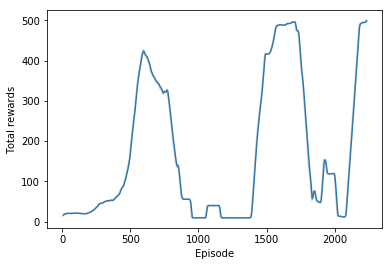

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

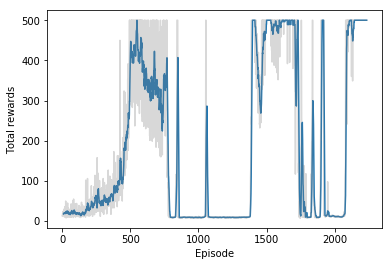

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

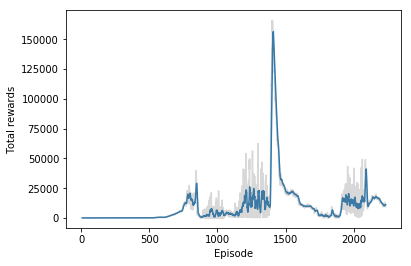

In [30]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

saver = tf.train.Saver()

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))

# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.